In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.losses import mse

2023-10-06 15:49:59.488753: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-06 15:49:59.516918: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-06 15:49:59.517745: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-06 15:50:00.116629: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
n_el = 16
r_obj = 0.4
dist_exc = 8
step_meas = 4

load_path = f"data/{n_el=}_{r_obj=}_{dist_exc=}_{step_meas=}/"

if os.path.isdir(load_path):
    print("This directory exists...continue")
else:
    print("You have to generate the data...")

This directory exists...continue


In [3]:
V = np.load("saves/" + load_path.split("/")[1] + "_v_data.npy", allow_pickle=True)

In [4]:
# creates overlapping segments with a length of nseg
nseg = 2
X0 = [V[n : n + nseg, :] for n in range(V.shape[0] - nseg + 1)]  # is this nseg+1 right?
X0 = np.array(X0)

Y0 = np.array(V[nseg - 1 :])  # is this -1 right?

In [5]:
# proof that the shift is right
print(np.allclose(X0[0], V[0:nseg, :]))
print(np.allclose(X0[244], V[244 : 244 + nseg, :]))

True
True


In [6]:
x_train, y_train = train_test_split(X0, test_size=0.1, shuffle=False)
x_val, y_val = train_test_split(Y0, test_size=0.1, shuffle=False)

In [7]:
y_val.shape

(25, 192)

In [8]:
print(x_train.shape, x_val.shape)
print(y_train.shape, y_val.shape)

(223, 2, 192) (223, 192)
(25, 2, 192) (25, 192)


In [9]:
# Define the dimensionality of the input data
input_dim = 192

# Define the latent space dimension
latent_dim = 2

# Encoder Network
encoder_inputs = tf.keras.Input(shape=(input_dim,))
x = layers.Dense(128, activation="relu")(encoder_inputs)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)


# Reparameterization Trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(
        shape=(tf.keras.backend.shape(z_mean)[0], latent_dim), mean=0.0, stddev=1.0
    )
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon


z = layers.Lambda(sampling)([z_mean, z_log_var])

encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
# Decoder Network
decoder_inputs = tf.keras.Input(shape=(latent_dim,))
x = layers.Dense(128, activation="relu")(decoder_inputs)
outputs = layers.Dense(input_dim, activation="sigmoid")(x)
decoder = models.Model(decoder_inputs, outputs, name="decoder")

# VAE Model
outputs = decoder(encoder(encoder_inputs)[2])
vae = models.Model(encoder_inputs, outputs, name="vae")

# Loss function: combination of reconstruction loss and KL divergence
reconstruction_loss = mse(encoder_inputs, outputs)
kl_loss = -0.5 * tf.keras.backend.sum(
    1 + z_log_var - tf.keras.backend.exp(z_log_var) - tf.keras.backend.square(z_mean),
    axis=-1,
)
vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
# Compile the VAE model
vae.compile(optimizer="adam")
# Display model summary
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 192)]                0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  25220     ['input_1[0][0]']             
                              (None, 2),                                                          
                              (None, 2)]                                                          
                                                                                                  
 decoder (Functional)        (None, 192)                  25152     ['encoder[0][2]']             
                                                                                                

2023-10-06 15:50:01.270747: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [10]:
vae.fit(x_val, epochs=100, batch_size=32)

Epoch 1/100
7/7 [==============================] - 1s 2ms/step - loss: 0.2142
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 0.1077
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0894
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0690
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0563
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0458
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0386
Epoch 8/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0313
Epoch 9/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0250
Epoch 10/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0205
Epoch 11/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0168
Epoch 12/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0150
Epoch 13/100
7/7 [==============================] - 0s 3ms/st

1/1 [==============================] - 0s 13ms/step


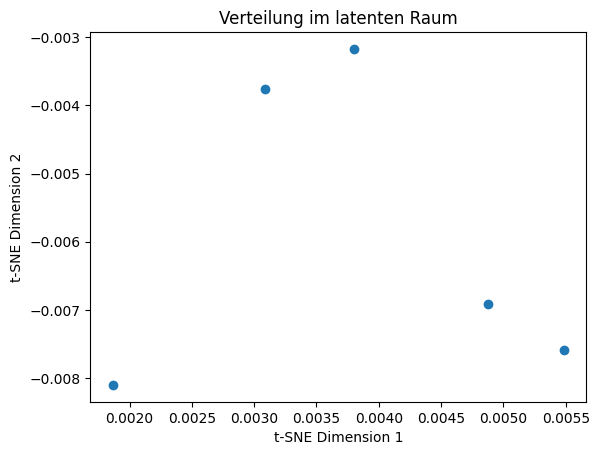

In [23]:
num_samples_to_visualize = 100
latent_vectors = encoder.predict(y_val[:5])[0]

# Plotte die Verteilung im latenten Raum
plt.scatter(latent_vectors[:,0], latent_vectors[:,1])
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Verteilung im latenten Raum')
plt.show()


In [17]:
np.array(latent_vectors[0])

array([ 0.00380286, -0.00317447], dtype=float32)

1/1 [==============================] - 0s 13ms/step


<StemContainer object of 3 artists>

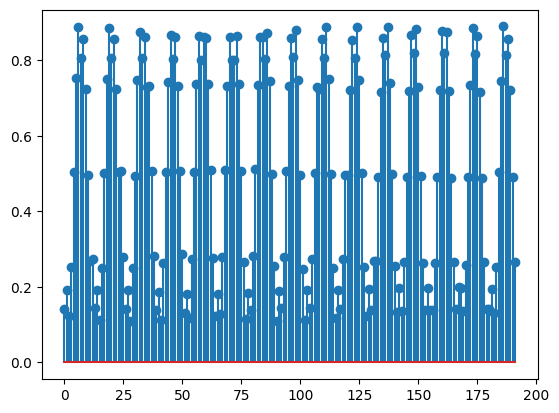

In [26]:
plt.stem(decoder.predict(latent_vectors)[1])

<StemContainer object of 3 artists>

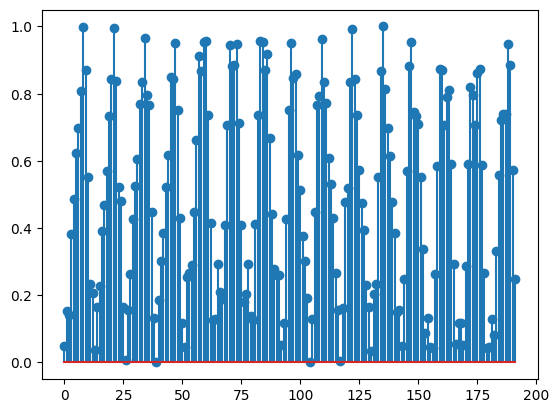

In [27]:
plt.stem(y_val[1])